In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# # Define the directory containing the images
# #test_image = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# Load the metadata from the Excel file
# metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
# print(metadata.head())

# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only the valid DAPI images
# metadata = metadata[metadata['filename'].str.endswith('_DAPI.tif')]
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Display the first few rows of the updated metadata
# metadata.head()


2024-11-22 02:16:34.236583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732270594.326908     947 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732270594.351303     947 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 02:16:34.579045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Prepare training, val, test data
def load_image_opencv(image_path, target_size=(256, 256)):
    # Decode the image path from bytes to string
    image_path = image_path.numpy().decode('utf-8')
    
    # Read the TIFF image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not read image at path: {image_path}")
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Clip the image values to the range [400, 4000]
    image = np.clip(image, 400, 4000)
    
    # Normalize the image to [0, 1]
    min_val = 400.0
    max_val = 4000.0
    image = image.astype(np.float32)
    image = (image - min_val) / (max_val - min_val)
    
    # Add channel dimension if the image is grayscale
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    return image

def load_data_wrapper(path, dose):
    image = tf.py_function(
        func=load_image_opencv,
        inp=[path],
        Tout=tf.float32
    )
    image.set_shape([256, 256, 1])  # Ensure the shape is set for TensorFlow
    # Modified return image, {'dose_output': dose, 'particle_output': ptype} 
    return image, dose

# Function to prepare dataset (as defined previously)
def prepare_dataset(metadata, batch_size=32):
    # Extract file paths and doses
    paths = metadata['filepath'].values.astype(str)
    doses = metadata['dose_Gy'].values.astype(np.float32)

    # Create dataset with (path, dose)
    dataset = tf.data.Dataset.from_tensor_slices((paths, doses))
    
    # Map the dataset to load and preprocess the images
    dataset = dataset.map(lambda path, dose: load_data_wrapper(path, dose),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



# Define the mapping for particle types
particle_type_mapping = {'Fe': 0, 'X-ray': 1}

# Apply the mapping to create 'particle_type_encoded'
metadata['particle_type_encoded'] = metadata['particle_type'].map(particle_type_mapping)

# Verify that the column is added
# print(metadata.head())

# Filter metadata for hr_post_exposure == 4
filtered_metadata = metadata[(metadata['hr_post_exposure'] == 4) & (metadata['particle_type'] == 'X-ray')]

# Define the ratios for train, validation, and test splits
train_ratio = 0.7  # 70% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.1   # 10% for testing

# Ensure the ratios add up to 1 within a tolerance
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must add up to 1.0"

# Calculate the sizes dynamically
total_size = len(filtered_metadata)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size  # Remaining for test

# Shuffle and split the metadata
shuffled_metadata = filtered_metadata.sample(frac=1, random_state=42).reset_index(drop=True)
train_metadata = shuffled_metadata[:train_size]
val_metadata = shuffled_metadata[train_size:train_size + val_size]
test_metadata = shuffled_metadata[train_size + val_size:]

# Verify the sizes
print(f"Train size: {len(train_metadata)}, Validation size: {len(val_metadata)}, Test size: {len(test_metadata)}")

# Prepare datasets using the previously defined function
train_dataset = prepare_dataset(train_metadata, batch_size=32)
val_dataset = prepare_dataset(val_metadata, batch_size=32)
test_dataset = prepare_dataset(test_metadata, batch_size=32)


Train size: 9785, Validation size: 2795, Test size: 1399


I0000 00:00:1732270599.668907     947 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:33:00.0, compute capability: 8.6


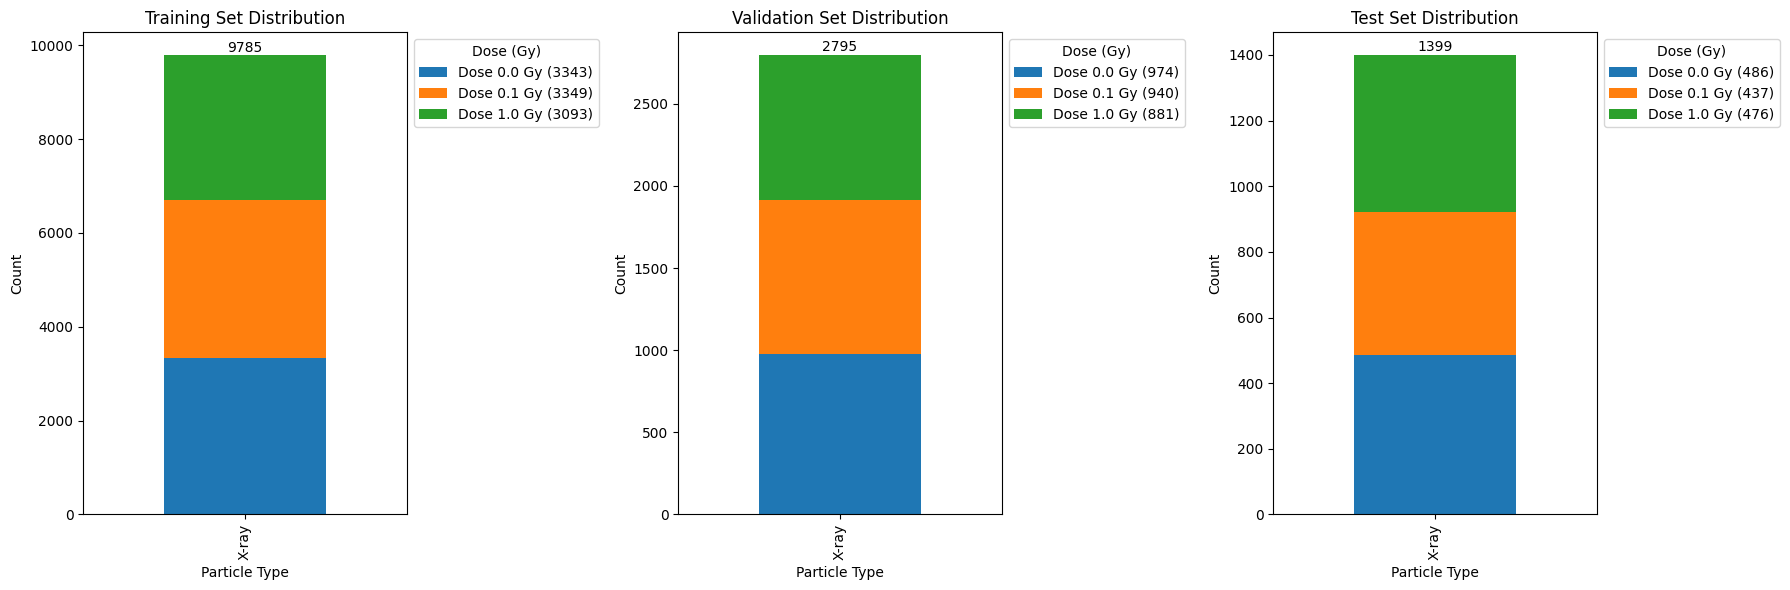

In [3]:
# Check set split

# Function to add total count annotations for each group
def annotate_group_totals(ax, data):
    for i, patch in enumerate(ax.patches):
        if i % len(data.columns) == 0:  # Add annotation only for the first bar of each group
            x = patch.get_x() + patch.get_width() / 2
            total = data.iloc[i // len(data.columns)].sum()
            ax.annotate(f'{int(total)}', (x, total + 5), ha='center', va='bottom', fontsize=10, color='black')

# Function to create legend labels with counts
def create_legend_labels(data):
    labels = []
    for dose in data.columns:
        count = data[dose].sum()
        labels.append(f"Dose {dose} Gy ({int(count)})")
    return labels

# Plot all sets: training, validation, and test
plt.figure(figsize=(18, 6))

# Training set plot
plt.subplot(1, 3, 1)
train_counts = train_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
train_ax = train_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(train_ax, train_counts)
plt.title('Training Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for training set
train_labels = create_legend_labels(train_counts)
plt.legend(train_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Validation set plot
plt.subplot(1, 3, 2)
val_counts = val_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
val_ax = val_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(val_ax, val_counts)
plt.title('Validation Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for validation set
val_labels = create_legend_labels(val_counts)
plt.legend(val_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Test set plot
plt.subplot(1, 3, 3)
test_counts = test_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
test_ax = test_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(test_ax, test_counts)
plt.title('Test Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for test set
test_labels = create_legend_labels(test_counts)
plt.legend(test_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Import required libraries
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

# Initialize W&B
wandb.init(
    project="dose-prediction",  # W&B project name
    config={
        "input_shape": (256, 256, 1),
        "batch_size": 32,
        "learning_rate": 1e-4,
        "epochs": 20,
        "loss_function": "mean_squared_error",
        "optimizer": "Adam",
        "architecture": "U-Net Regression",
    },
    tags=["xray_4hr", "unet", "400clip"]
)


def unet_for_regression(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Final layer for single-dose prediction
    g = layers.GlobalAveragePooling2D()(c9)  # Pool across the spatial dimensions
    outputs = layers.Dense(1, activation='linear')(g)  # Single dose value

    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = unet_for_regression(wandb.config.input_shape)
model.compile(
    optimizer=Adam(learning_rate=wandb.config.learning_rate),
    loss=wandb.config.loss_function,
    metrics=['mae']
)

# Model summary
wandb.log({"Model Summary": model.summary()})

# Define callbacks
metrics_logger = WandbMetricsLogger(log_freq="epoch")
model_checkpoint = WandbModelCheckpoint(filepath="model-checkpoints/model.epoch{epoch:02d}.keras")

# Define the custom evaluation callback
# Create interactive visualizations in W&B to analyze the model's performance epoch-by-epoch.
class DosePredictionEval(WandbEvalCallback):
    def __init__(self, validation_data, data_table_columns, pred_table_columns):
        super().__init__(data_table_columns, pred_table_columns)
        self.x, self.y = validation_data  # Batch of validation images and labels

    def add_ground_truth(self, logs=None):
        for idx, (image, label) in enumerate(zip(self.x, self.y)):
            self.data_table.add_data(idx, wandb.Image(image.numpy()), label.numpy())

    def add_model_predictions(self, epoch, logs=None):
        preds = self.model.predict(self.x)
        for idx, pred in enumerate(preds):
            self.pred_table.add_data(
                epoch, idx, wandb.Image(self.x[idx].numpy()), self.y[idx].numpy(), pred
            )


# Extract a batch from val_dataset
val_images, val_labels = next(iter(val_dataset))

# Define the evaluation callback
eval_callback = DosePredictionEval(
    validation_data=(val_images, val_labels),
    data_table_columns=["index", "image", "true dose"],
    pred_table_columns=["epoch", "index", "image", "true dose", "predicted dose"],
)


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    callbacks=[metrics_logger, model_checkpoint, eval_callback],
)



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: walt_. Use `wandb login --relogin` to force relogin


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

wandb:   33 of 33 files downloaded.  
I0000 00:00:1732270613.147219    1324 service.cc:148] XLA service 0x7f00ac0025e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732270613.147472    1324 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-22 02:16:53.273059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732270613.862831    1324 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1732270659.516125    1324 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/stepstep - loss: 0.2316 - mae: 0.39
306/306 ━━━━━━━━━━━━━━━━━━━━ 315s 864ms/step - loss: 0.2315 - mae: 0.3925 - val_loss: 0.1996 - val_mae: 0.3920


In [ ]:
# Plot loss curves
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Save and log loss plot
plt.savefig("loss_curve.png")
wandb.log({"Loss Curve": wandb.Image("loss_curve.png")})
plt.close()

# Plot MAE curves
plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Training vs Validation MAE')

# Save and log MAE plot
plt.savefig("mae_curve.png")
wandb.log({"MAE Curve": wandb.Image("mae_curve.png")})
# plt.close()


In [9]:
# Evaluate and log test metrics
from sklearn.metrics import r2_score, mean_absolute_error

true_doses = test_metadata['dose_Gy'].values
test_results = model.evaluate(test_dataset)

# Predict using the model
predicted_doses = model.predict(test_dataset).flatten()

# Log metrics to W&B
wandb.log({
    "Test Loss": test_results[0],
    "Test MAE": test_results[1],
    "R²": r2_score(true_doses, predicted_doses)
})

# Create a comparison metric (absolute error)
absolute_errors = abs(true_doses - predicted_doses)

# Create a comparison table
comparison_table = pd.DataFrame({
    "Filename": test_metadata["filepath"].values,
    "Actual Dose": true_doses,
    "Predicted Dose": predicted_doses,
    "Absolute Error": absolute_errors
})

# Log sorted comparison table to W&B
sorted_comparison_table = comparison_table.sort_values(by="Absolute Error", ascending=True).reset_index(drop=True)
wandb_table = wandb.Table(dataframe=sorted_comparison_table)
wandb.log({"Comparison Table": wandb_table})

# Log best and worst examples
best_examples = sorted_comparison_table.head(5)
worst_examples = sorted_comparison_table.tail(5)

for _, row in best_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Best Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

for _, row in worst_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Worst Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

# Print overall MAE
overall_mae = mean_absolute_error(true_doses, predicted_doses)
print(f"Overall MAE: {overall_mae}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.1996 - mae: 0.3927
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step
Overall MAE: 0.40588218648149077


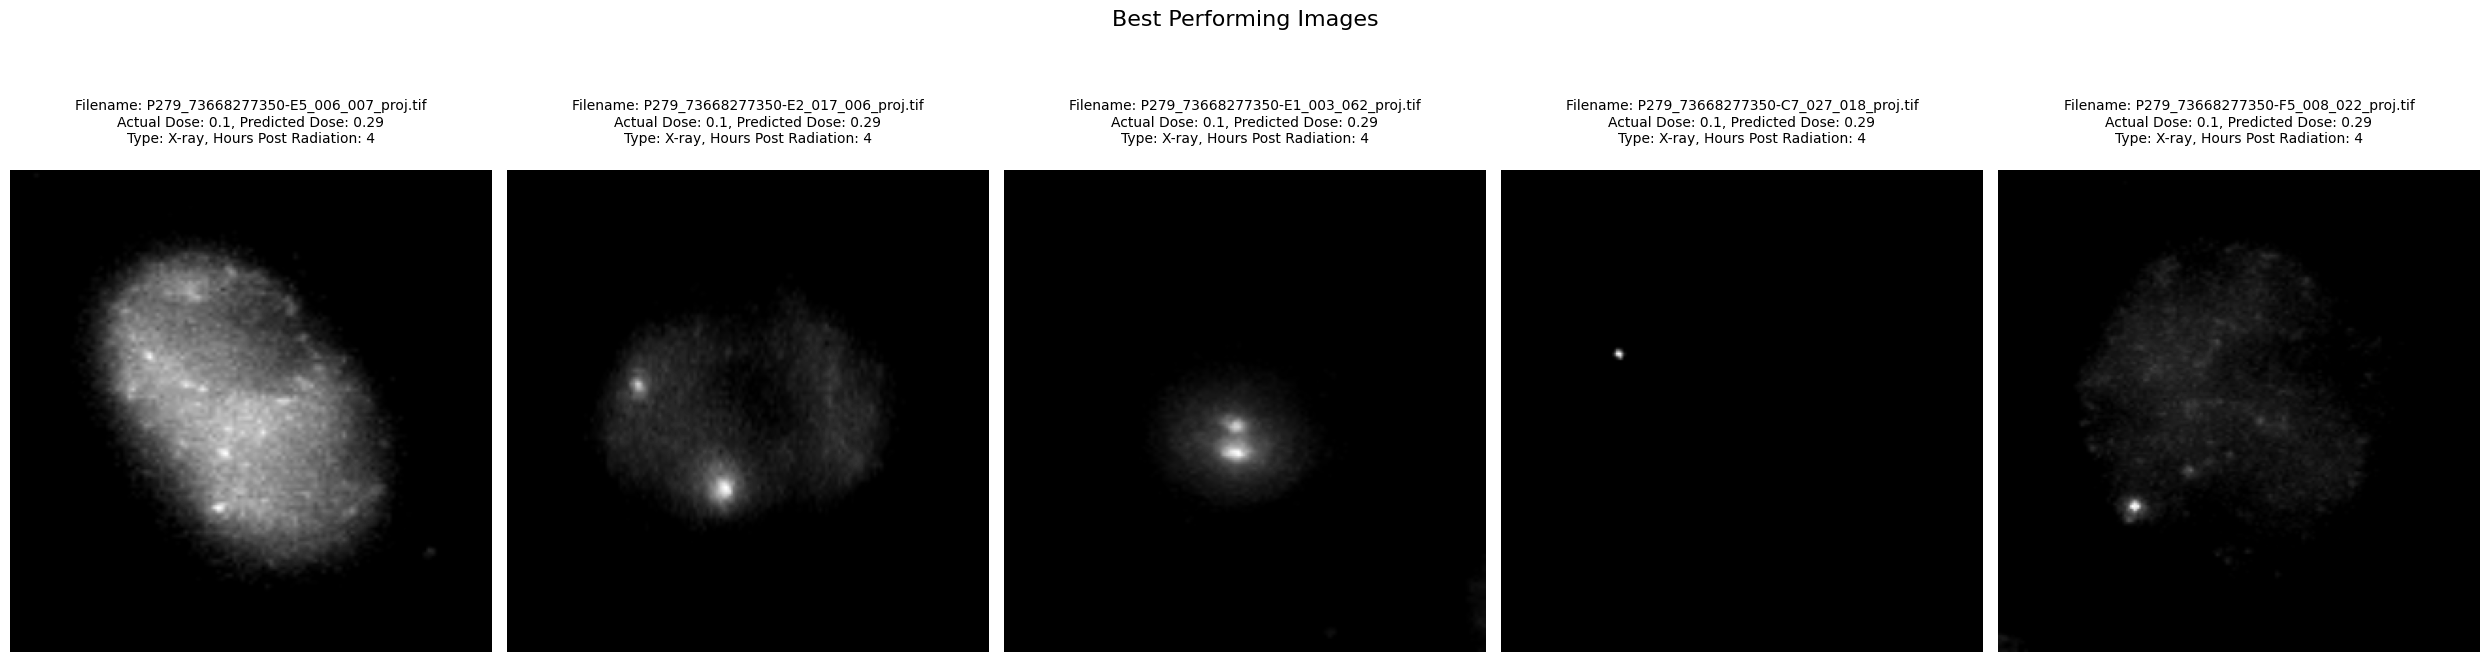

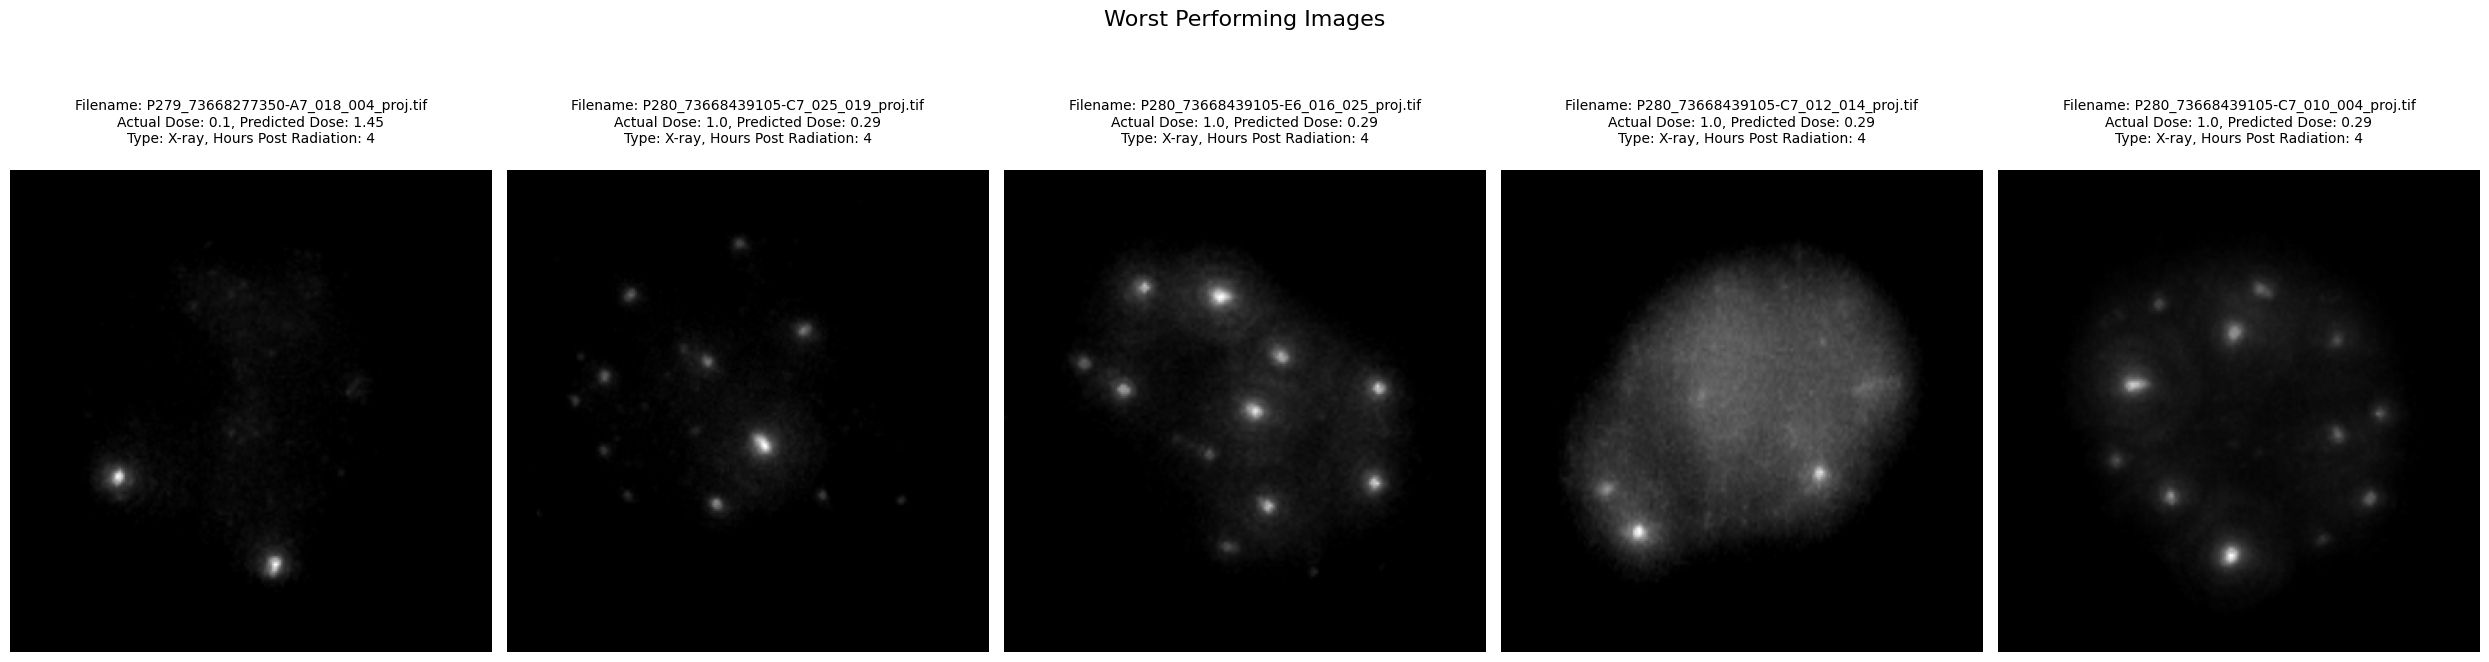

In [10]:
# Sort the data for best and worst performing images
best_performing = comparison_table.sort_values(by="Absolute Error", ascending=True).head(5)
worst_performing = comparison_table.sort_values(by="Absolute Error", ascending=False).head(5)

# Function to preprocess images (clip and normalize)
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Clip image values to [400, 4000]
    image = np.clip(image, 400, 4000)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Normalize to [0, 1]
    image = (image - 400) / (4000 - 400)
    
    return image

# Function to load and display images with captions
def plot_images(data, title, metadata):
    fig, axes = plt.subplots(1, len(data), figsize=(25, 8))  # Increase figure width and height
    fig.suptitle(title, fontsize=16)

    for idx, (filename, actual, predicted, error) in enumerate(zip(data["Filename"], 
                                                                  data["Actual Dose"], 
                                                                  data["Predicted Dose"], 
                                                                  data["Absolute Error"])):
        # Preprocess image
        image = preprocess_image(filename)
        
        # Plot image
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
        
        # Fetch metadata for captions
        metadata_row = metadata[metadata["filepath"] == filename].iloc[0]
        caption = (
            f"Filename: {filename.split('/')[-1]}\n"
            f"Actual Dose: {actual}, Predicted Dose: {predicted:.2f}\n"
            f"Type: {metadata_row['particle_type']}, Hours Post Radiation: {metadata_row['hr_post_exposure']}"
        )
        axes[idx].set_title(caption, fontsize=10, pad=20)  # Add padding to separate the title from the plot

    plt.tight_layout()
    plt.show()


# Plot best-performing images
plot_images(best_performing, "Best Performing Images", test_metadata)

# Plot worst-performing images
plot_images(worst_performing, "Worst Performing Images", test_metadata)


In [11]:
mae_per_dose = {}
for dose in [0.0, 0.1, 1.0]:
    subset = comparison_table[comparison_table['Actual Dose'] == dose]
    mae = subset['Absolute Error'].mean()
    print(f"MAE for Dose {dose}: {mae}")
    mae_per_dose[f"MAE for Dose {dose}"] = mae

# Log all MAE values together
wandb.log(mae_per_dose)


MAE for Dose 0.0: 0.300905703271858
MAE for Dose 0.1: 0.2020983283116015
MAE for Dose 1.0: 0.7001513395489765


In [14]:
import seaborn as sns

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=comparison_table, x='Actual Dose', y='Absolute Error')
plt.title("Absolute Error Distribution by Dose")
plt.xlabel("Actual Dose")
plt.ylabel("Absolute Error")

# Save the plot as an image
plt.savefig("absolute_error_boxplot.png")

# Log the plot to W&B
wandb.log({"Absolute Error Boxplot": wandb.Image("absolute_error_boxplot.png")})

# Close the plot to free memory
plt.close()

# Finish the W&B run
wandb.finish()


MAE for Dose 0.0,▁
MAE for Dose 0.1,▁
MAE for Dose 1.0,▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/mae,▁
epoch/val_loss,▁
